In [81]:
from datetime import timedelta
from time import localtime, strftime, time

import matplotlib as mpt
import numpy as np
import pandas as pd
import scipy.spatial
from IPython.display import HTML, display
from matplotlib import pyplot as plt

import libsvm.python.svm as svm
import libsvm.python.svmutil as svmutil

In [2]:
# utils


class TimeEval:
    """
    Needed modules:
    from datetime import timedelta
    from time import localtime, strftime, time
    """

    def __init__(self):
        self.start = time()

    def secondsToStr(self):
        return strftime("%Y-%m-%d %H:%M:%S", localtime())

    def log(self, s="", display_elapsed=False):
        print("=" * 50)
        print(self.secondsToStr(), "-", s)
        if display_elapsed is True:
            elapsed = time() - self.start
            print("Elapsed time:", str(timedelta(seconds=elapsed)))
        print("=" * 50)

    def endlog(self):
        print("=" * 50)
        elapsed = time() - self.start
        print("Total elapsed:", str(timedelta(seconds=elapsed)))
        print("=" * 50 + "\n")


th_style = [
    ("font-size", "18px"),
    ("text-align", "center"),
    ("font-weight", "bold"),
    ("color", "#6d6d6d"),
    ("background-color", "#f7f7f9"),
]
td_style = [("font-size", "18px")]
styles = [dict(selector="th", props=th_style), dict(selector="td", props=td_style)]

In [3]:
X_train = np.genfromtxt("./data/X_train.csv", delimiter=",")
X_test = np.genfromtxt("./data/X_test.csv", delimiter=",")
Y_train = np.genfromtxt("./data/Y_train.csv", delimiter=",")
Y_test = np.genfromtxt("./data/Y_test.csv", delimiter=",")

## Data format:
- label1 1:pixel1 2:pixel2 ... 784:pixel784
- label2 1:pixel1 2:pixel2 ... 784:pixel784
- ...

In [4]:
def preprocess(in_data, data_label, outname):
    data = []
    for img in in_data:
        row = ""
        for idx, pixel in enumerate(img):
            if pixel != 0:  # sparse data
                if row != "":
                    row += " "
                row += str(idx + 1) + ":" + str(pixel)
        row += "\n"
        data.append(row)
    with open(outname, "w") as file:
        for datarow, label in zip(data, data_label):
            datarow = str(label) + " " + datarow
            file.write(datarow)

In [5]:
preprocess(X_train, Y_train, "data_train")
preprocess(X_test, Y_test, "data_test")

In [30]:
def evaluate_kernel_performance(cross_validation=False):
    """
    Cross validation: only using training set
    """
    params = {"Linear": "-t 0", "Polynomial": "-t 1", "RBF": "-t 2"}
    y, x = svmutil.svm_read_problem("data_train")
    ty, tx = svmutil.svm_read_problem("data_test")
    for kernel, param in params.items():
        time_ev = TimeEval()
        display_msg = "Using kernel: %s" % kernel
        time_ev.log(display_msg)
        m = svmutil.svm_train(y, x, param)
        p_label, p_acc, p_val = svmutil.svm_predict(y, x, m)
        p_label, p_acc, p_val = svmutil.svm_predict(ty, tx, m)

In [31]:
evaluate_kernel_performance()

2019-05-16 17:39:57 - Using kernel: Linear
Accuracy = 100% (5000/5000) (classification)
Accuracy = 95.08% (2377/2500) (classification)
2019-05-16 17:40:04 - Using kernel: Polynomial
Accuracy = 34.34% (1717/5000) (classification)
Accuracy = 34.68% (867/2500) (classification)
2019-05-16 17:41:09 - Using kernel: RBF
Accuracy = 96.88% (4844/5000) (classification)
Accuracy = 95.32% (2383/2500) (classification)


In [10]:
def gridSearch(kernel, c_options, gamma_options=None, coef0_options=None, degree_options=None):
    """
    Do cross validation here
    """
    params = {
        "Linear": "-t 0 -v 3",
        "Polynomial": "-t 1 -v 3",
        "RBF": "-t 2 -v 3",
        "linear_RBF": "-t 4 -v 3",
    }

    y, x = svmutil.svm_read_problem("data_train")
    best_acc = 0
    best_param = None
    result_table = []
    if kernel == "Linear":
        for c in c_options:
            param = params[kernel] + " -c " + str(c)
            acc = svmutil.svm_train(y, x, param)
            if acc > best_acc:
                best_acc = acc
                best_param = param
            result_table.append({"c": c, "opt": param, "acc": str(acc) + "%"})
    elif kernel == "Polynomial":
        for c in c_options:
            for g in gamma_options:
                for r in coef0_options:
                    for d in degree_options:
                        param = "%s -c %f -g %f -r %d -d %d" % (params[kernel], c, g, r, d)
                        acc = svmutil.svm_train(y, x, param)
                        if acc > best_acc:
                            best_acc = acc
                            best_param = param
                        result_table.append(
                            {"c": c, "g": g, "r": r, "d": d, "opt": param, "acc": str(acc) + "%"}
                        )
    elif kernel == "RBF":
        for c in c_options:
            for g in gamma_options:
                param = "%s -c %f -g %f" % (params[kernel], c, g)
                acc = svmutil.svm_train(y, x, param)
                if acc > best_acc:
                    best_acc = acc
                    best_param = param
                result_table.append({"c": c, "g": g, "opt": param, "acc": str(acc) + "%"})
    elif kernel == "linear_RBF":
        for i in range(3):
            y, x = svmutil.svm_read_problem("data_precomputed_x_train_%d" % i)
            g = gamma_options[i]
            for c in c_options:
                param = "%s -c %f" % (params[kernel], c)
                acc = svmutil.svm_train(y, x, param)
                if acc > best_acc:
                    best_acc = acc
                    best_param = param
                result_table.append({"c": c, "g": g, "opt": param, "acc": str(acc) + "%"})
    return best_acc, best_param, pd.DataFrame(result_table)

In [11]:
linear_acc, linear_param, linear_result = gridSearch("Linear", [0.001, 0.01, 0.1, 1, 10, 100, 1000])

Cross Validation Accuracy = 95.28%
Cross Validation Accuracy = 96.9%
Cross Validation Accuracy = 96.78%
Cross Validation Accuracy = 96.06%
Cross Validation Accuracy = 95.94%
Cross Validation Accuracy = 96.24%
Cross Validation Accuracy = 96.3%


In [12]:
linear_result.sort_values(by=["acc"], ascending=False).style.set_table_styles(styles)

,acc,c,opt
1,96.89999999999999%,0.01,-t 0 -v 3 -c 0.01
2,96.78%,0.1,-t 0 -v 3 -c 0.1
6,96.3%,1000,-t 0 -v 3 -c 1000
5,96.24000000000001%,100,-t 0 -v 3 -c 100
3,96.06%,1,-t 0 -v 3 -c 1
4,95.94%,10,-t 0 -v 3 -c 10
0,95.28%,0.001,-t 0 -v 3 -c 0.001


In [13]:
poly_acc, poly_param, poly_result = gridSearch(
    "Polynomial",
    c_options=[0.01, 1, 100],
    gamma_options=[1 / 100, 1 / 392, 1 / 784],
    coef0_options=[0, 1],
    degree_options=[2, 3, 4],
)

Cross Validation Accuracy = 77.84%
Cross Validation Accuracy = 58.72%
Cross Validation Accuracy = 45.56%
Cross Validation Accuracy = 92.76%
Cross Validation Accuracy = 94.32%
Cross Validation Accuracy = 95.44%
Cross Validation Accuracy = 46.08%
Cross Validation Accuracy = 28.68%
Cross Validation Accuracy = 23.86%
Cross Validation Accuracy = 80.6%
Cross Validation Accuracy = 86.72%
Cross Validation Accuracy = 89.18%
Cross Validation Accuracy = 46.16%
Cross Validation Accuracy = 28.6%
Cross Validation Accuracy = 23.54%
Cross Validation Accuracy = 77.86%
Cross Validation Accuracy = 76.92%
Cross Validation Accuracy = 81.14%
Cross Validation Accuracy = 97.52%
Cross Validation Accuracy = 96.24%
Cross Validation Accuracy = 92.36%
Cross Validation Accuracy = 97.44%
Cross Validation Accuracy = 97.92%
Cross Validation Accuracy = 98.08%
Cross Validation Accuracy = 92.82%
Cross Validation Accuracy = 69.44%
Cross Validation Accuracy = 32.48%
Cross Validation Accuracy = 96.62%
Cross Validation Accur

In [14]:
poly_result.sort_values(by=["acc"], ascending=False).style.set_table_styles(styles)

,acc,c,d,g,opt,r
23,98.08%,1,4,0.01,-t 1 -v 3 -c 1.000000 -g 0.010000 -r 1 -d 4,1
41,97.98%,100,4,0.01,-t 1 -v 3 -c 100.000000 -g 0.010000 -r 1 -d 4,1
22,97.92%,1,3,0.01,-t 1 -v 3 -c 1.000000 -g 0.010000 -r 1 -d 3,1
42,97.86%,100,2,0.00255102,-t 1 -v 3 -c 100.000000 -g 0.002551 -r 0 -d 2,0
48,97.8%,100,2,0.00127551,-t 1 -v 3 -c 100.000000 -g 0.001276 -r 0 -d 2,0
36,97.76%,100,2,0.01,-t 1 -v 3 -c 100.000000 -g 0.010000 -r 0 -d 2,0
40,97.76%,100,3,0.01,-t 1 -v 3 -c 100.000000 -g 0.010000 -r 1 -d 3,1
37,97.54%,100,3,0.01,-t 1 -v 3 -c 100.000000 -g 0.010000 -r 0 -d 3,0
18,97.52%,1,2,0.01,-t 1 -v 3 -c 1.000000 -g 0.010000 -r 0 -d 2,0
47,97.5%,100,4,0.00255102,-t 1 -v 3 -c 100.000000 -g 0.002551 -r 1 -d 4,1


In [15]:
RBF_acc, RBF_param, RBF_result = gridSearch(
    "RBF", c_options=[0.01, 0.1, 1, 10, 100], gamma_options=[1 / 100, 1 / 392, 1 / 784]
)

Cross Validation Accuracy = 91.82%
Cross Validation Accuracy = 83.14%
Cross Validation Accuracy = 81.28%
Cross Validation Accuracy = 96.18%
Cross Validation Accuracy = 94.22%
Cross Validation Accuracy = 92.68%
Cross Validation Accuracy = 97.74%
Cross Validation Accuracy = 96.72%
Cross Validation Accuracy = 96.14%
Cross Validation Accuracy = 98.12%
Cross Validation Accuracy = 97.6%
Cross Validation Accuracy = 97.1%
Cross Validation Accuracy = 98.22%
Cross Validation Accuracy = 97.42%
Cross Validation Accuracy = 97.02%


In [16]:
RBF_result.sort_values(by=["acc"], ascending=False).style.set_table_styles(styles)

,acc,c,g,opt
12,98.22%,100,0.01,-t 2 -v 3 -c 100.000000 -g 0.010000
9,98.11999999999999%,10,0.01,-t 2 -v 3 -c 10.000000 -g 0.010000
6,97.74000000000001%,1,0.01,-t 2 -v 3 -c 1.000000 -g 0.010000
10,97.6%,10,0.00255102,-t 2 -v 3 -c 10.000000 -g 0.002551
13,97.42%,100,0.00255102,-t 2 -v 3 -c 100.000000 -g 0.002551
11,97.1%,10,0.00127551,-t 2 -v 3 -c 10.000000 -g 0.001276
14,97.02%,100,0.00127551,-t 2 -v 3 -c 100.000000 -g 0.001276
7,96.72%,1,0.00255102,-t 2 -v 3 -c 1.000000 -g 0.002551
3,96.17999999999999%,0.1,0.01,-t 2 -v 3 -c 0.100000 -g 0.010000
8,96.14%,1,0.00127551,-t 2 -v 3 -c 1.000000 -g 0.001276


In [1]:
def linear_RBF_kernel(x1, x2, gamma):
    exp_term = (
        np.sum(x1 ** 2, axis=1).reshape(len(x1), 1) - 2 * x1.dot(x2.T) + np.sum(x2 ** 2, axis=1)
    )
    rbf_kernel = -gamma * exp_term
    return np.exp(rbf_kernel) + x1.dot(x2.T)

- get a Gram matrix where the $(i, j)^{th}$ element is $|x_i - x_j|^2$
- using the identity $(x - y)^T (x - y) = x^T x + y^T y - 2 x^T y$

In [18]:
def sparse_matrix(x, label, outname):
    x = np.insert(x, 0, np.arange(1, len(x) + 1), axis=1)
    data = []
    for row in x:
        datarow = ""
        for idx, val in enumerate(row):
            if val != 0:
                if datarow != "":
                    datarow += " "
                datarow += str(idx) + ":" + str(val)
        datarow += "\n"
        data.append(datarow)
    with open(outname, "w") as file:
        for datarow, label in zip(data, label):
            datarow = str(label) + " " + datarow
            file.write(datarow)

In [19]:
"""
 build precomputed x_train data
- 0.01: _0.csv
- 0.00255: _1.csv
- 0.0012: _2.csv
"""

for i, g in enumerate([1 / 100, 1 / 392, 1 / 784]):
    precomputed_xtrain = linear_RBF_kernel(X_train, X_train, gamma=g)
    sparse_matrix(precomputed_xtrain, Y_train, "data_precomputed_x_train_%d" % i)

In [38]:
precomputed_xtest = linear_RBF_kernel(X_test, X_train, gamma=(1 / 392))
sparse_matrix(precomputed_xtest, Y_test, "data_precomputed_x_test")

In [39]:
linear_RBF_acc, linear_RBF_param, linear_RBF_result = gridSearch(
    "linear_RBF", c_options=[0.01, 0.1, 1, 10, 100], gamma_options=[1 / 100, 1 / 392, 1 / 784]
)

Cross Validation Accuracy = 96.76%
Cross Validation Accuracy = 96.92%
Cross Validation Accuracy = 96.12%
Cross Validation Accuracy = 96.04%
Cross Validation Accuracy = 96.62%
Cross Validation Accuracy = 97.02%
Cross Validation Accuracy = 97.08%
Cross Validation Accuracy = 96.34%
Cross Validation Accuracy = 95.86%
Cross Validation Accuracy = 96.3%
Cross Validation Accuracy = 96.76%
Cross Validation Accuracy = 96.9%
Cross Validation Accuracy = 96.58%
Cross Validation Accuracy = 96.3%
Cross Validation Accuracy = 96.18%


In [40]:
linear_RBF_result.sort_values(by=["acc"], ascending=False).style.set_table_styles(styles)

,acc,c,g,opt
6,97.08%,0.1,0.00255102,-t 4 -v 3 -c 0.100000
5,97.02%,0.01,0.00255102,-t 4 -v 3 -c 0.010000
1,96.92%,0.1,0.01,-t 4 -v 3 -c 0.100000
11,96.89999999999999%,0.1,0.00127551,-t 4 -v 3 -c 0.100000
0,96.76%,0.01,0.01,-t 4 -v 3 -c 0.010000
10,96.76%,0.01,0.00127551,-t 4 -v 3 -c 0.010000
4,96.61999999999999%,100,0.01,-t 4 -v 3 -c 100.000000
12,96.58%,1,0.00127551,-t 4 -v 3 -c 1.000000
7,96.34%,1,0.00255102,-t 4 -v 3 -c 1.000000
9,96.3%,100,0.00255102,-t 4 -v 3 -c 100.000000


In [41]:
def removeCrossValidPar(param):
    list_param = param.split(" ")
    del_idx = list_param.index("-v")
    del list_param[del_idx : del_idx + 2]
    return_par = ""
    for elem in list_param:
        if return_par != "":
            return_par += " "
        return_par += elem
    return return_par

In [42]:
# Predict testing set
time_ev = TimeEval()
y, x = svmutil.svm_read_problem("data_train")
ty, tx = svmutil.svm_read_problem("data_test")
compare_table = []

# Linear
linear_par = removeCrossValidPar(linear_param)
time_ev.log("Using Linear kernel")
m = svmutil.svm_train(y, x, linear_par)
_, linear_acc, _ = svmutil.svm_predict(y, x, m)
_, test_linear_acc, _ = svmutil.svm_predict(ty, tx, m)
compare_table.append(
    {"kernel": "linear", "train_acc": linear_acc[0], "test_acc": test_linear_acc[0]}
)

# Poly
poly_par = removeCrossValidPar(poly_param)
time_ev.log("Using polynomial kernel")
m = svmutil.svm_train(y, x, poly_par)
_, poly_acc, _ = svmutil.svm_predict(y, x, m)
_, test_poly_acc, _ = svmutil.svm_predict(ty, tx, m)
compare_table.append(
    {"kernel": "Polynomial", "train_acc": poly_acc[0], "test_acc": test_poly_acc[0]}
)

# RBF
RBF_par = removeCrossValidPar(RBF_param)
time_ev.log("Using RBF kernel")
m = svmutil.svm_train(y, x, RBF_par)
_, rbf_acc, _ = svmutil.svm_predict(y, x, m)
_, test_rbf_acc, _ = svmutil.svm_predict(ty, tx, m)
compare_table.append({"kernel": "RBF", "train_acc": rbf_acc[0], "test_acc": test_rbf_acc[0]})

# Linear+RBF
linear_RBF_par = removeCrossValidPar(linear_RBF_param)
y, x = svmutil.svm_read_problem("data_precomputed_x_train_1")
ty, tx = svmutil.svm_read_problem("data_precomputed_x_test")
time_ev.log("Using linear+RBF kernel")
m = svmutil.svm_train(y, x, linear_RBF_par)
_, linear_rbf_acc, _ = svmutil.svm_predict(y, x, m)
_, test_linear_rbf_acc, _ = svmutil.svm_predict(ty, tx, m)
compare_table.append(
    {"kernel": "linear+RBF", "train_acc": linear_rbf_acc[0], "test_acc": test_linear_rbf_acc[0]}
)

2019-05-18 12:02:42 - Using Linear kernel
Accuracy = 97.86% (4893/5000) (classification)
Accuracy = 95.96% (2399/2500) (classification)
2019-05-18 12:02:54 - Using polynomial kernel
Accuracy = 99.96% (4998/5000) (classification)
Accuracy = 98% (2450/2500) (classification)
2019-05-18 12:03:04 - Using RBF kernel
Accuracy = 100% (5000/5000) (classification)
Accuracy = 98.16% (2454/2500) (classification)
2019-05-18 12:04:17 - Using linear+RBF kernel
Accuracy = 99.2% (4960/5000) (classification)
Accuracy = 95.8% (2395/2500) (classification)


In [43]:
pd.DataFrame(compare_table).style.set_table_styles(styles)

,kernel,test_acc,train_acc
0,linear,95.96,97.86
1,Polynomial,98,99.96
2,RBF,98.16,100
3,linear+RBF,95.8,99.2


## Part 2: Plot data

In [77]:
Plot_data = np.genfromtxt("./data/Plot_X.csv", delimiter=",")
Plot_Y = np.genfromtxt("./data/Plot_Y.csv", delimiter=",")

In [191]:
def plotFig(title, label):
    colors = ["magenta", "cyan", "pink"]
    plt.figure(figsize=(6, 6))
    plt.title(title, fontsize=22)
    plt.scatter(Plot_data[:, 0], Plot_data[:, 1], c=label, cmap=mpt.colors.ListedColormap(colors))


def plotSV(svdict):
    sv_data = []
    for sv in svdict:
        x = sv[1]
        y = sv[2]
        sv_data.append([x, y])
    sv_data = np.array(sv_data)
    plt.scatter(sv_data[:, 0], sv_data[:, 1], marker="+", c="black")

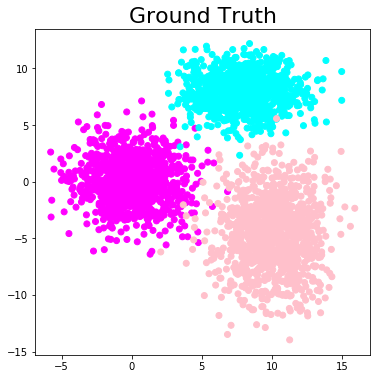

In [177]:
plotFig("Ground Truth", Plot_Y)

In [178]:
preprocess(Plot_data, Plot_Y, "Plot_data")
y, x = svmutil.svm_read_problem("Plot_data")

Accuracy = 99.5667% (2987/3000) (classification)


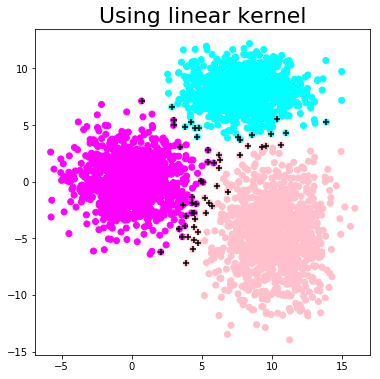

In [198]:
# Linear kernel
m = svmutil.svm_train(y, x, "-t 0")
pred_label, _, _ = svmutil.svm_predict(y, x, m)
plotFig("Using linear kernel", pred_label)
plotSV(m.get_SV())
plt.savefig("Linear")

Accuracy = 99.3333% (2980/3000) (classification)


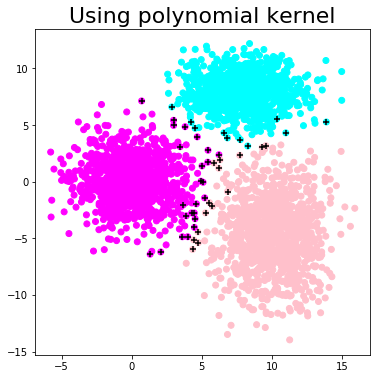

In [199]:
# Polynomial kernel
m = svmutil.svm_train(y, x, "-t 1")
pred_label, _, _ = svmutil.svm_predict(y, x, m)
plotFig("Using polynomial kernel", pred_label)
plotSV(m.get_SV())
plt.savefig("Poly")

Accuracy = 99.4667% (2984/3000) (classification)


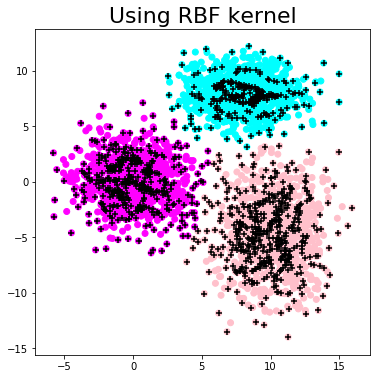

In [200]:
# RBF kernel
m = svmutil.svm_train(y, x, "-t 2")
pred_label, _, _ = svmutil.svm_predict(y, x, m)
plotFig("Using RBF kernel", pred_label)
plotSV(m.get_SV())
plt.savefig("RBF")

In [239]:
precomputed_plot_x = linear_RBF_kernel(Plot_data, Plot_data, gamma=0.01)
sparse_matrix(precomputed_plot_x, Plot_Y, "precomputed_plotx")

In [240]:
# Linear+RBF kernel
y, x = svmutil.svm_read_problem("precomputed_plotx")
m = svmutil.svm_train(y, x, "-t 4")
pred_label, _, _ = svmutil.svm_predict(y, x, m)
idx = []
for svs in m.get_SV():
    idx.append(svs[0] - 1)

Accuracy = 99.5667% (2987/3000) (classification)


In [241]:
lrbf_support_vectors = []
for i in idx:
    lrbf_support_vectors.append(Plot_data[int(i)])
lrbf_support_vectors = np.array(lrbf_support_vectors)

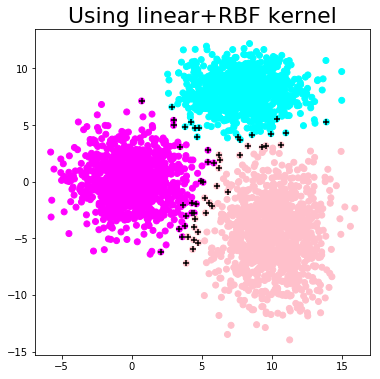

In [242]:
plotFig("Using linear+RBF kernel", pred_label)
plt.scatter(lrbf_support_vectors[:, 0], lrbf_support_vectors[:, 1], marker="+", c="black")
plt.savefig("Linear_RBF")